In [1]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision, torchaudio
import torch.optim as optim
import scipy as sp
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [2]:
root_dir = os.path.join('/data', 'EPIC-KITCHENS')
annotations_dir = os.path.join('..', 'data', 'annotations')
train = True
filename = 'EPIC_100_train_clean.pkl'

In [3]:
def load_data(filename):
    '''
    Load the WAV file and its label.
    Args :
        • filename: str. The path of a WAV file.
    Returns A tuple of two Pandas DataFrame objects:
        • signals: A DataFrame with the following columns:
            • seconds: The time in seconds.
            • AcclX: The acceleration along the x-axis.
            • AcclY: The acceleration along the y-axis.
            • AcclZ: The acceleration along the z-axis.
            • GyroX: The angular velocity along the x-axis.
            • GyroY: The angular velocity along the y-axis.
            • GyroZ: The angular velocity along the z-axis.
        • sampling_rate: The sampling rate of the WAV file.
    '''
    # TODO: Load the WAV file and its label
    df_accl, df_gyro = pd.read_csv(filename + '-accl.csv'), pd.read_csv(filename + '-gyro.csv')
    # seconds = df_accl['Milliseconds'] / 1000.0
    seconds = df_accl['Milliseconds']
    seconds.name = "seconds"
    sampling_rate = int(len(df_accl) / (seconds.iloc[-1] - seconds.iloc[0]))
    seconds = torch.tensor(seconds.values, dtype=torch.float32)
    accl, gyro = df_accl[["AcclX", "AcclY", "AcclZ"]], df_gyro[["GyroX", "GyroY", "GyroZ"]]
    accl = torch.tensor(
        np.array([
            accl['AcclX'].to_numpy(),
            accl['AcclY'].to_numpy(),
            accl['AcclZ'].to_numpy()
        ]), dtype=torch.float32)
    gyro = torch.tensor(
        np.array([
            gyro['GyroX'].to_numpy(),
            gyro['GyroY'].to_numpy(),
            gyro['GyroZ'].to_numpy()
        ]), dtype=torch.float32)
    return seconds, (accl, gyro), sampling_rate

In [23]:
def trim_data(data, downsampling_rate, ws=3):
    '''
    Trim the data to a fixed window size.
    Args:
        • data: A tuple of two torch.Tensor objects. The first tensor is the milliseconds data and the second tensor is the acceleration data.
        • downsampling_rate: int. The desired downsampling rate.
        • ws: int. The window size in seconds.
    Returns:
        • accl: The acceleration data with shape (3, ws * downsampling_rate).
        • downsampling_rate: The new downsampling rate.

    '''
    milliseconds, amplitudes = data
    ws_extended = ws * downsampling_rate
    start = 0
    end = ws_extended
    
    

In [4]:
df = pd.read_pickle(os.path.join(annotations_dir, filename))
df = df.dropna()
df = df.reset_index(drop=True)
df

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_102,00:00:01.100,00:00:00.54,00:00:02.23,27,111,take knife and plate,take,0,knife,4,"[knife, plate]","[4, 2]"
1,P01,P01_102,00:00:07.600,00:00:07.49,00:00:09.05,374,452,move spatula and colander,move,11,spatula,20,"[spatula, colander]","[20, 39]"
2,P01,P01_102,00:00:29.851,00:00:29.66,00:00:30.84,1483,1542,take knife,take,0,knife,4,[knife],[4]
3,P01,P01_102,00:03:44.600,00:03:44.45,00:03:45.00,11222,11250,wipe surface,wipe,2,surface,42,[surface],[42]
4,P01,P01_102,00:03:45.600,00:03:45.61,00:03:46.01,11280,11300,move glass,move,11,glass,10,[glass],[10]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37450,P37,P37_103,00:06:16.903,00:06:17.17,00:06:17.67,18858,18883,turn off tap,turn-off,8,tap,0,[tap],[0]
37451,P37,P37_103,00:06:22.154,00:06:17.86,00:06:23.77,18893,19188,take pan,take,0,pan,5,[pan],[5]
37452,P37,P37_103,00:06:26.404,00:06:23.45,00:06:32.66,19172,19633,pour out boiled water,pour-out,9,water:boiled,27,[water:boiled],[27]
37453,P37,P37_103,00:00:41.151,00:00:40.57,00:00:44.19,2028,2209,debone chicken thighs,debone,30,thigh:chicken,57,[thigh:chicken],[57]


In [25]:
line = df.iloc[0, :]
start = pd.Timestamp(line['start_timestamp'])
stop = pd.Timestamp(line['stop_timestamp'])

stop - start

Timedelta('0 days 00:00:01.690000')

### Controllo sulla durata
Controllo fatto per vedere se l'ultimo stop_timestamp combacia con l'effettiva durata dei timestamp nel file dell'accelerometro.

In [26]:
df.where(df['video_id'] == 'P01_102').sort_values(by='start_timestamp').dropna()

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_102,00:00:01.100,00:00:00.54,00:00:02.23,27.0,111.0,take knife and plate,take,0.0,knife,4.0,"[knife, plate]","[4, 2]"
1,P01,P01_102,00:00:07.600,00:00:07.49,00:00:09.05,374.0,452.0,move spatula and colander,move,11.0,spatula,20.0,"[spatula, colander]","[20, 39]"
39,P01,P01_102,00:00:10.350,00:00:09.66,00:00:10.84,483.0,542.0,open bin,open,3.0,bin,36.0,[bin],[36]
50,P01,P01_102,00:00:11.600,00:00:11.09,00:00:11.94,554.0,597.0,take knife,take,0.0,knife,4.0,[knife],[4]
61,P01,P01_102,00:00:12.600,00:00:12.00,00:00:13.00,600.0,650.0,move orange skin into the bin,move-into,11.0,skin:orange,48.0,"[skin:orange, bin]","[48, 36]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,P01,P01_102,00:04:27.100,00:04:25.30,00:04:29.37,13265.0,13468.0,close lid,close,4.0,lid,6.0,[lid],[6]
28,P01,P01_102,00:04:29.101,00:04:29.39,00:04:30.69,13469.0,13534.0,take container,take,0.0,container,21.0,[container],[21]
29,P01,P01_102,00:04:30.100,00:04:30.05,00:04:31.49,13502.0,13574.0,open fridge,open,3.0,fridge,12.0,[fridge],[12]
30,P01,P01_102,00:04:31.100,00:04:30.85,00:04:32.10,13542.0,13605.0,put container into fridge,put-into,5.0,container,21.0,"[container, fridge]","[21, 12]"


In [5]:

participant_id = df.loc[0, 'participant_id']
video_id = df.loc[0, 'video_id']
clip_path = os.path.join(root_dir, participant_id, 'meta_data', video_id)
seconds, (accl, gyro), sampling_rate = load_data(clip_path)

In [28]:
seconds_ts = pd.Series(seconds.numpy())
seconds_ts

0             0.000000
1             4.444445
2             8.888889
3            13.333333
4            17.777779
             ...      
54088    271974.750000
54089    271979.812500
54090    271984.843750
54091    271989.906250
54092    271994.937500
Length: 54093, dtype: float32

In [29]:
diff = seconds_ts.diff()[1:]
diff

1        4.444445
2        4.444445
3        4.444444
4        4.444446
5        4.444443
           ...   
54088    5.062500
54089    5.062500
54090    5.031250
54091    5.062500
54092    5.031250
Length: 54092, dtype: float32

### Osservazione
Il seguente grafico ci dice che il sampling non è uniforme. Di seguito sono riportate le statistiche su P01_01_102, mentre il grafico riporta i dati fino a 10k entries per motivi di visualizzazione.

In [30]:
mean, median, max_min = diff.mean(), diff.median(), (diff.max(), diff.min())
print(f'mean: {mean}\nmedian: {median}\nmax_min: {max_min}')

mean: 5.028376579284668
median: 5.046875
max_min: (5.0625, 4.44439697265625)


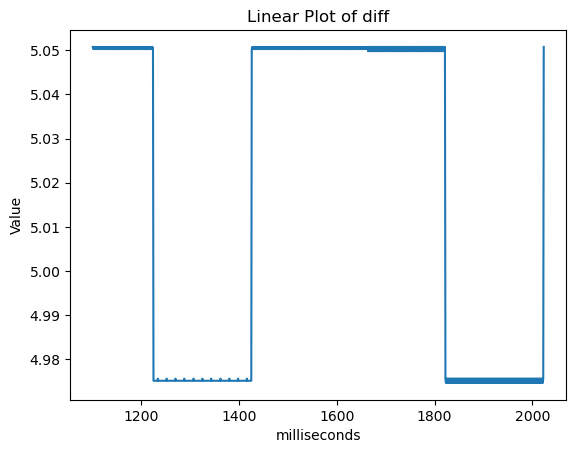

In [31]:
import matplotlib.pyplot as plt

plt.plot(diff[1100:2023])
plt.title('Linear Plot of diff')
plt.xlabel('milliseconds')
plt.ylabel('Value')
plt.show()


In [32]:
seconds_ts.between(seconds_ts.iloc[0], seconds_ts.iloc[-1])

0        True
1        True
2        True
3        True
4        True
         ... 
54088    True
54089    True
54090    True
54091    True
54092    True
Length: 54093, dtype: bool

In [33]:
seconds.shape, accl.shape, gyro.shape

(torch.Size([54093]), torch.Size([3, 54093]), torch.Size([3, 54093]))

### Q1: come si può vedere di seguito, i minuti sono 4, ma in realtà la clip dura 02.23-00.54. Bisogna trimmare l'IMU? 

In [34]:
df.iloc[0, :]

participant_id                          P01
video_id                            P01_102
narration_timestamp            00:00:01.100
start_timestamp                 00:00:00.54
stop_timestamp                  00:00:02.23
start_frame                              27
stop_frame                              111
narration              take knife and plate
verb                                   take
verb_class                                0
noun                                  knife
noun_class                                4
all_nouns                    [knife, plate]
all_noun_classes                     [4, 2]
Name: 0, dtype: object

In [35]:
duration = seconds[-1] - seconds[0]
(duration / 1000.0)/60.0

tensor(4.5332)

# Data Cleaning
Come abbiamo visto nel plot precedente, non tutti i timestamp seguono lo stesso sampling rate. Quindi, per uniformarli, occorre fare un preprocessing. Iniziamo con l'interpolazione.

In [36]:
from scipy.interpolate import interp1d

## Metodo 1: usare i timestamp delle annotations

In [37]:
df.loc[0, 'narration_timestamp'], df.loc[0, 'stop_timestamp']

('00:00:01.100', '00:00:02.23')

In [38]:
def datetime_to_milliseconds(timestamp: str):
    time = timestamp.split(':')
    seconds, micro = time[2].split('.')
    hours = int(time[0])
    minutes = int(time[1])
    return (hours * 3600 + minutes * 60 + int(seconds)) * 1000 + int(micro)

In [39]:
resampling_rate = 200
start_timestamp = datetime_to_milliseconds(df.loc[0, 'narration_timestamp'])
stop_timestamp = datetime_to_milliseconds(df.loc[0, 'stop_timestamp'])
print(start_timestamp, stop_timestamp)


1100 2023


In [40]:
action_idx = ((seconds >= start_timestamp) & (seconds <= stop_timestamp)).nonzero().flatten()
action_ms, action_amplitudes = seconds[action_idx], accl[:, action_idx]
action_ms.shape, action_amplitudes.shape

(torch.Size([188]), torch.Size([3, 188]))

In [41]:
secs = action_ms / 1000.0
target_time_s = torch.linspace(
    secs[0],
    secs[-1],
    steps=int(torch.round((secs[-1] - secs[0]) * resampling_rate))
    )
interpolate_accl_x = interp1d(secs, action_amplitudes[0], kind='linear', axis=0)

In [42]:
accl_x_interp = interpolate_accl_x(target_time_s)

In [43]:
target_time_s.shape, accl_x_interp.shape

(torch.Size([183]), (183,))

In [44]:
diff_interp_accl_x = pd.Series(secs.numpy()).diff()[1:]
diff_interp_accl_x

1      0.004902
2      0.004902
3      0.004902
4      0.004902
5      0.004902
         ...   
183    0.004902
184    0.005050
185    0.005050
186    0.005051
187    0.005050
Length: 187, dtype: float32

In [45]:
mean, median, max_min = diff_interp_accl_x.mean(), diff_interp_accl_x.median(), (diff_interp_accl_x.max(), diff_interp_accl_x.min())
print(f'mean: {mean}\nmedian: {median}\nmax_min: {max_min}')

mean: 0.004905137699097395
median: 0.004902005195617676
max_min: (0.0050506591796875, 0.004901766777038574)


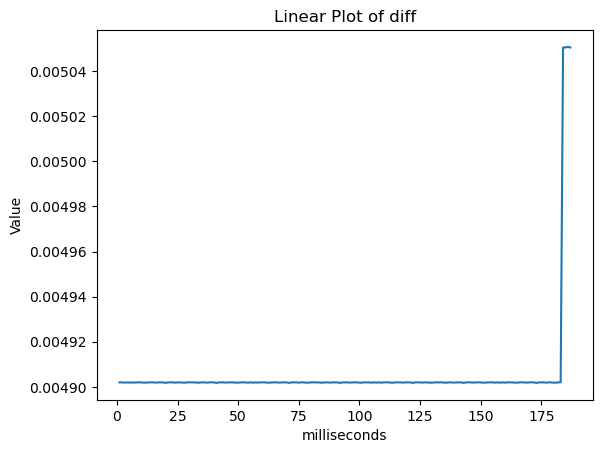

In [46]:
plt.plot(diff_interp_accl_x)
plt.title('Linear Plot of diff')
plt.xlabel('milliseconds')
plt.ylabel('Value')
plt.show()


In [47]:
def plot_signal(time, signal, title):
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

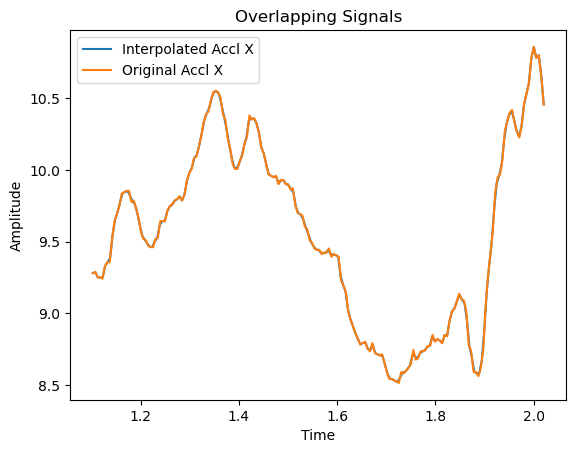

In [66]:
import matplotlib.pyplot as plt

# Plotting the first signal
plt.plot(target_time_s, accl_x_interp, label='Interpolated Accl X')

# Plotting the second signal
plt.plot(action_ms / 1000.0, action_amplitudes[0].numpy(), label='Original Accl X')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Overlapping Signals')

# Add legend
plt.legend()

# Show the plot
plt.show()


## Metodo 2: andare seguendo l'ultimo timestamp

In [6]:
sampling_rate = 200

In [7]:
last_second = int(np.ceil(seconds[-1]/1000))
last_second

272

In [8]:
accl_padded = torch.zeros((3, last_second * sampling_rate))
accl_padded.shape

torch.Size([3, 54400])

Faccio zero padding

In [9]:
accl[0].shape

torch.Size([54093])

In [10]:
accl_padded[:, :accl.size(1)] = accl
accl_padded.shape

torch.Size([3, 54400])

In [11]:
import librosa

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_frames = waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr

    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [12]:
accl_x_interp_torch = torch.tensor(accl_padded)

/tmp/ipykernel_14762/2958437491.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accl_x_interp_torch = torch.tensor(accl_padded)


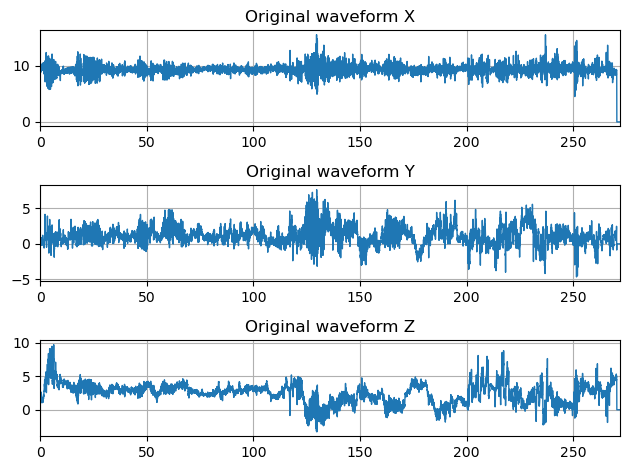

In [13]:
fig, axs = plt.subplots(3,1)
plot_waveform(accl_x_interp_torch[0], 200, title="Original waveform X", ax=axs[0])
plot_waveform(accl_x_interp_torch[1], 200, title="Original waveform Y", ax=axs[1])
plot_waveform(accl_x_interp_torch[2], 200, title="Original waveform Z", ax=axs[2])
# plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

# FFT
Investighiamo le frequenze

In [255]:
resample = T.Resample(200, 50)
accl_x_downsampled = resample(accl_x_interp_torch)

In [256]:
accl_fft = torch.fft.fft(
    accl_x_downsampled,
    dim=1,
)

In [253]:
accl_fft[0].max()

RuntimeError: "max_all" not implemented for 'ComplexFloat'

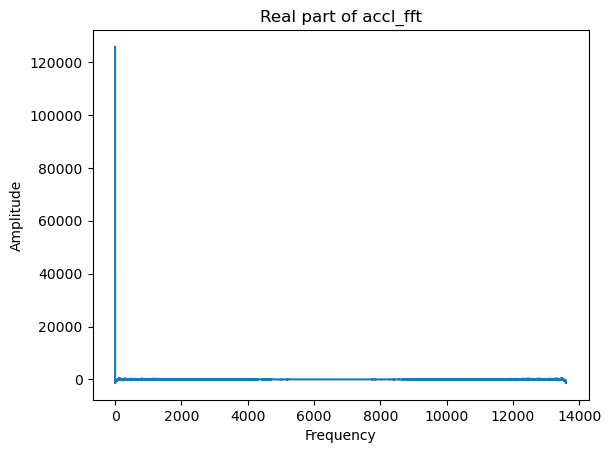

In [266]:
import matplotlib.pyplot as plt

# Plotting the real part of accl_fft
plt.plot(accl_fft[0].real)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Real part of accl_fft')
plt.show()


In [190]:
import torchaudio
def normalize_tensor(tensor):
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

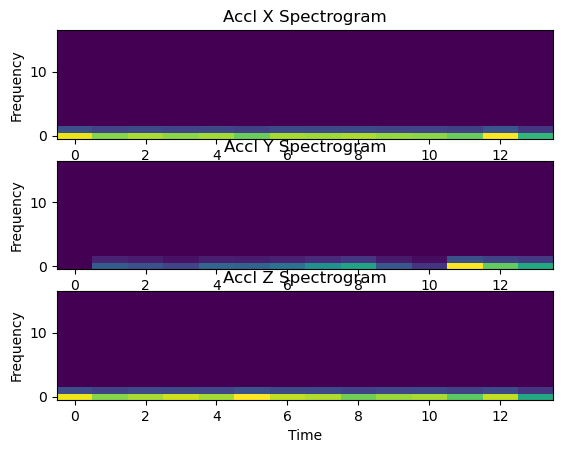

In [249]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,1)
axs[0].imshow(prova[0], aspect='auto', origin='lower')
axs[0].set_title('Accl X Spectrogram')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')
axs[1].imshow(prova[1], aspect='auto', origin='lower')
axs[1].set_title('Accl Y Spectrogram')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')
axs[2].imshow(prova[2], aspect='auto', origin='lower')
axs[2].set_title('Accl Z Spectrogram')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')
plt.show()


# Spectrogram

### TODO: calcolare (\# frequency bins, \# frames) in maniera adattiva

### Q2: Come comportarsi col tempo?
Non tutte le azioni hanno la stessa durata, e la dimensione dello spettrogramma dipendono dai parametri sopra. Questo implica che renderlo quadrato per il ViT è da studiare, perché si intacca la dimensione temporale e può portare a dei bias nel modello.

In [15]:
signal = torch.tensor(accl_x_interp, dtype=torch.float32)

NameError: name 'accl_x_interp' is not defined

In [14]:
def normalize_tensor(tensor):
    tensor = torch.from_numpy(tensor)
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

def cut_and_pad(signal, sampling_rate, seconds):
    padded_signal = torch.zeros(sampling_rate * seconds)
    if signal.shape[0] < sampling_rate * seconds:
        padded_signal = torch.zeros(sampling_rate * seconds)
        padded_signal[:signal.shape[0]] = signal
    else:
        padded_signal = signal[:sampling_rate * seconds]

    return padded_signal

In [34]:

b, a = sp.signal.iirfilter(4, Wn=5.0, fs=downsampling_rate, btype="low", ftype="butter")
mel_spectrogram.double()
spectrogram.double()

Spectrogram()

In [127]:
focus = 10000
sec = 2.5

prova_2s = accl_x_interp_torch[:, focus:focus + int(sampling_rate * sec)]
prova_2s = torchaudio.functional.resample(prova_2s, 200, 200)
# prova_2s = accl_x_interp_torch
# prova_2s = normalize_tensor(prova_2s.numpy())
# 

n_ffts = [32, 64, 128, 256]
hop_length = [2, 4, 8, 16]

specs = []
for i, n_fft in enumerate(n_ffts):
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        hop_length=4,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
    )
    spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = spectrogram(prova_2s)
    prova = librosa.power_to_db(prova)
    prova = normalize_tensor(prova)
    specs.append(prova)
# spectrogram_accl = librosa.power_to_db(prova)

In [128]:
for i in range(len(specs)):
    print(specs[i].shape) 

torch.Size([3, 17, 126])
torch.Size([3, 33, 126])
torch.Size([3, 65, 126])
torch.Size([3, 129, 126])


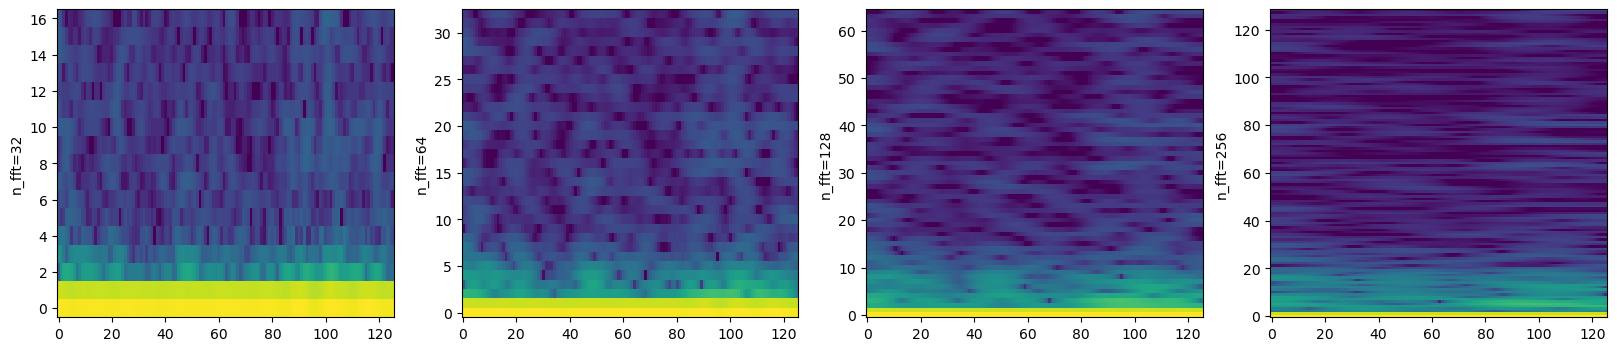

In [129]:
fig, axs = plt.subplots(1, len(specs), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)
# fig.tight_layout()

In [121]:
n_ffts = [32, 64, 128, 256]
hop_length = [2, 4, 8, 16]
downsampling_rate = 200
specs = []
for i, n_fft in enumerate(n_ffts):
    mel_spectrogram = T.MelSpectrogram(
        n_mels=20,
        sample_rate=downsampling_rate,
        n_fft=n_fft,
        hop_length=4,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
    )
    mel_spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = mel_spectrogram(prova_2s)
    prova = librosa.power_to_db(prova)
    prova = normalize_tensor(prova)
    specs.append(prova)

In [122]:
for spec in specs:
    print(spec.shape)

torch.Size([3, 20, 126])
torch.Size([3, 20, 126])
torch.Size([3, 20, 126])
torch.Size([3, 20, 126])


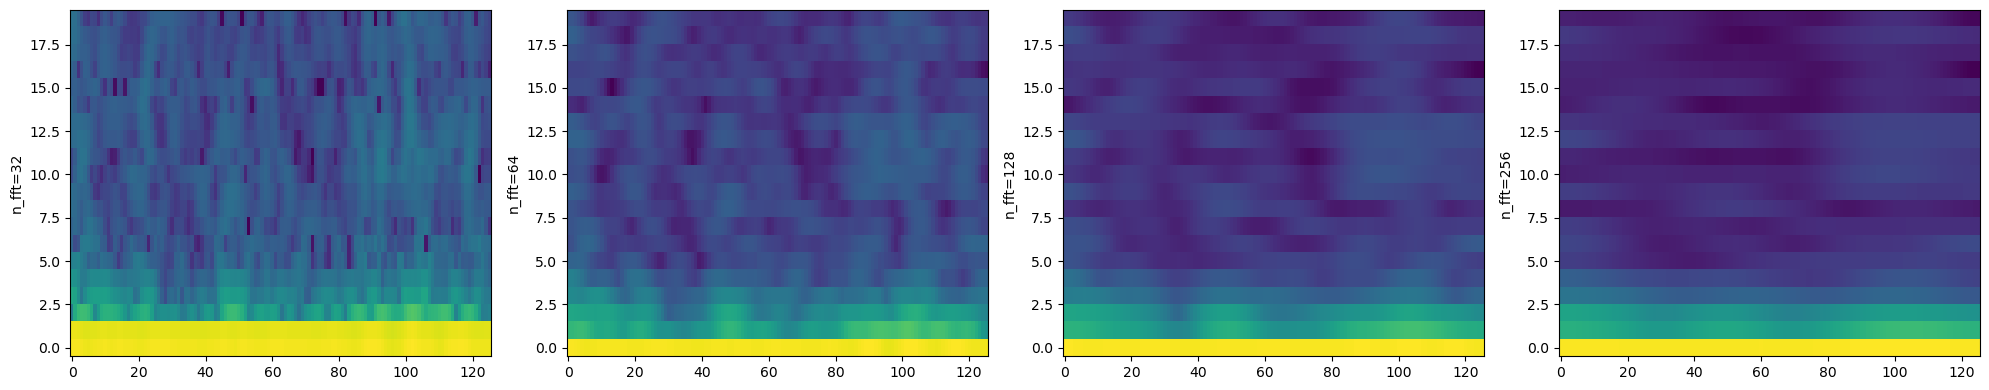

In [123]:
fig, axs = plt.subplots(1, len(specs), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()